In [29]:
from dataset_builder import create_train_batches, create_val_batches
from model_builder import UNetModel
import tensorflow as tf

# Airbus-Ship-Detection-Challenge
 I am solving a Kaggle task at https://www.kaggle.com/competitions/airbus-ship-detection, where the goal is to build masks for ship detection. The foundation of the solution is a U-net neural network architecture.
# Load data

To download the dataset, please follow the link https://www.kaggle.com/competitions/airbus-ship-detection/data and extract the archive into the "data" folder. Once done, you can run the "train_and_analysis.ipynb" file.

# Idea
The main challenges of my solution were time and class imbalance. In our dataset, ships occupied a small percentage of the area, and many images didn't contain any ships at all. To expedite the training process, I adopted the following strategy. I divided our images into 9 equal squares and trained the model only on the data (tensors with dimensions of 256x256x3) where the corresponding masks had values. By doing so, we reduced the class imbalance and significantly accelerated the training process.
# Model
You can look at my model using model.summary() . Main components is:
## conv block: 
A convolutional block composed of two convolutional layers with batch normalization and ReLU activation. It takes input inputs, applies convolutions, and returns the output.

## upconv block: 
An upsampling convolutional block that combines the upsampled features with skip connections from the encoder path. It performs transposed convolutions, concatenates the features, applies convolutions, and returns the output.

## attention gate: 
An attention gate that enhances the spatial information flow by calculating attention weights. It takes the features x and a gating signal g, applies convolutions, computes attention weights, and applies element-wise multiplication to the input features.

# Here are some ideas for improvement:

Dynamic thresholding: Instead of using a fixed threshold of 0.7 for considering pixels, calculate the threshold dynamically for each image based on the statistics of the ship area. This can help account for variations in lighting and other factors that may affect the predictions on different images.

DBSCAN for homogeneous backgrounds: Utilize DBSCAN (Density-Based Spatial Clustering of Applications with Noise) to identify homogeneous backgrounds in the images. By clustering pixels with similar characteristics, you can potentially separate the background from the foreground more accurately.

Selecting rectangular regions: Currently, the model predicts ship masks even for islands, ports, and other irregular shapes. Consider selecting only small regions that have a closer approximation to rectangular shape. This can help filter out false positives and focus on regions that are more likely to be ships.

In [2]:
TRAIN = 'data/train_v2/'
TEST = 'data/test_v2/'
SEGMENTATION = 'data/train_ship_segmentations_v2.csv'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Завантаження міток кораблів
df = pd.read_csv(SEGMENTATION)
df = df[df.EncodedPixels > '0']
train_len = round(len(df)*0.8)
df_val = df[train_len:]
df = df[:train_len]
print(train_len)
df.head()

73551


,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


In [4]:
train_batches = create_train_batches(df)
val_batches = create_val_batches(df_val)

In [7]:
model = UNetModel()

In [8]:
#model.train(train_batches, val_batches)

Epoch 1/10
 132/5000 [..............................] - ETA: 10:00 - loss: 0.4357 - accuracy: 0.9078 - iou_score: 0.1548 - recall_1: 0.5562 - f1_score: 0.2289

KeyboardInterrupt: 

In [10]:
model.model.load_weights('models/model-001.h5')

In [25]:
def read_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image) / 255.0  # normalize pixel values if needed
    return tf.convert_to_tensor(image)

def visualize_image_mask(image, mask):
    image = image.numpy()
    mask = np.where(mask < 0.7, 0, mask)
    # Create a copy of the image
    masked_image = image.copy()

    # Find the indices where mask is 1
    indices = np.where(mask == 1)

    # Change the color of the masked pixels

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Use squeeze() to remove single-dimensional entries from the shape of mask
    plt.title('Mask')


    plt.show()

In [26]:
img_paths = [f'{TEST}/1a36da3c8.jpg',f'{TEST}/00a3ab3cc.jpg',f'{TEST}/00dc34840.jpg',f'{TEST}/0a19c1ef7.jpg',f'{TEST}/0b8cde107.jpg']


1/1 [==============================] - 0s 45ms/step


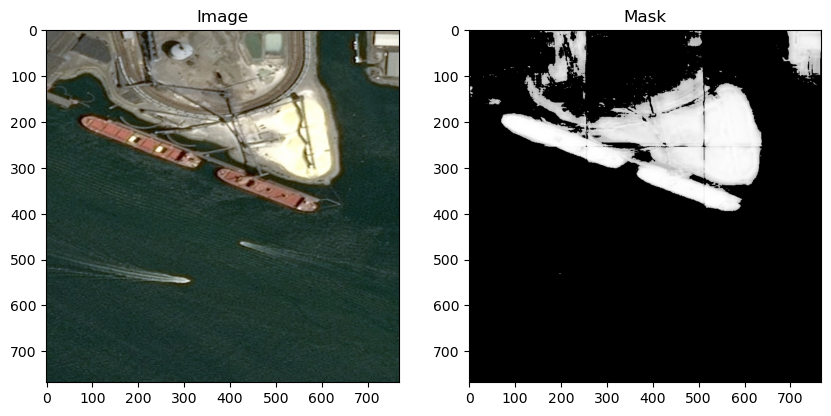

1/1 [==============================] - 0s 43ms/step


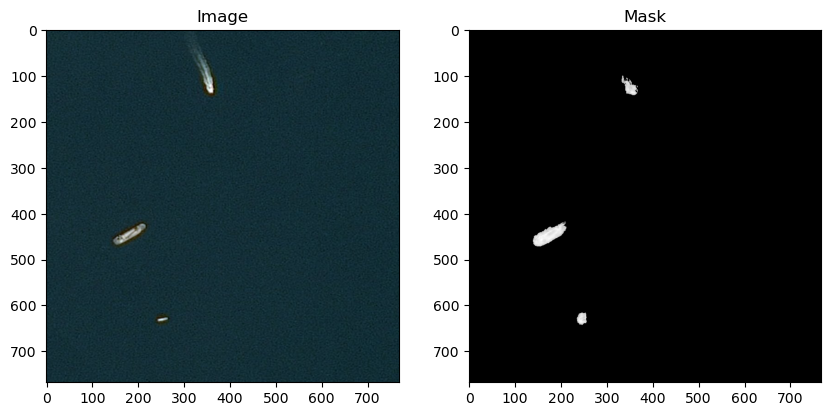

1/1 [==============================] - 0s 42ms/step


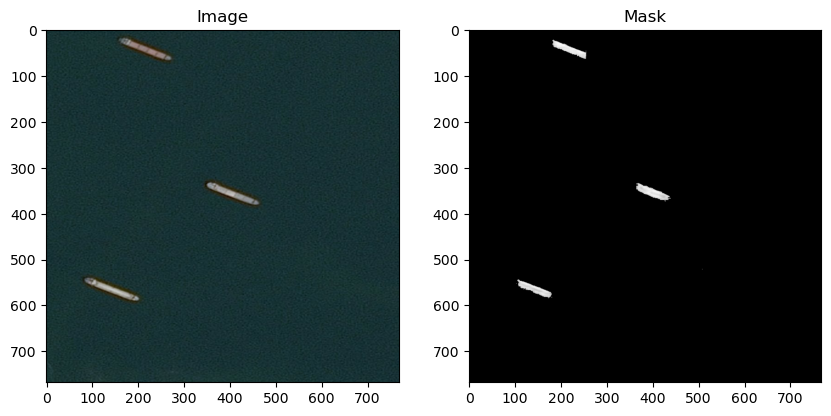

1/1 [==============================] - 0s 42ms/step


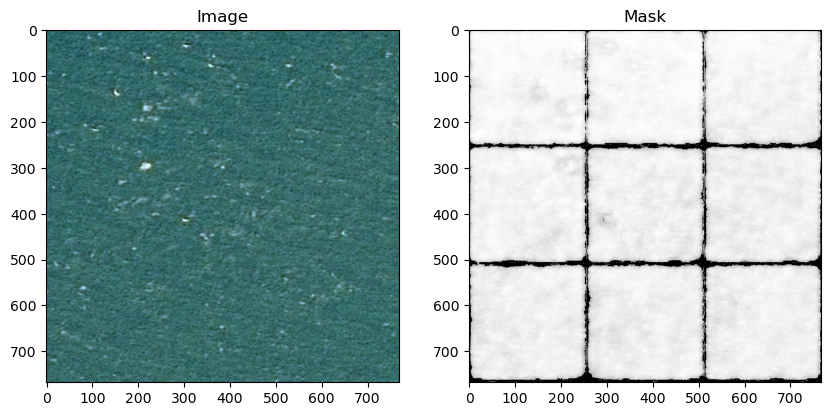

1/1 [==============================] - 0s 41ms/step


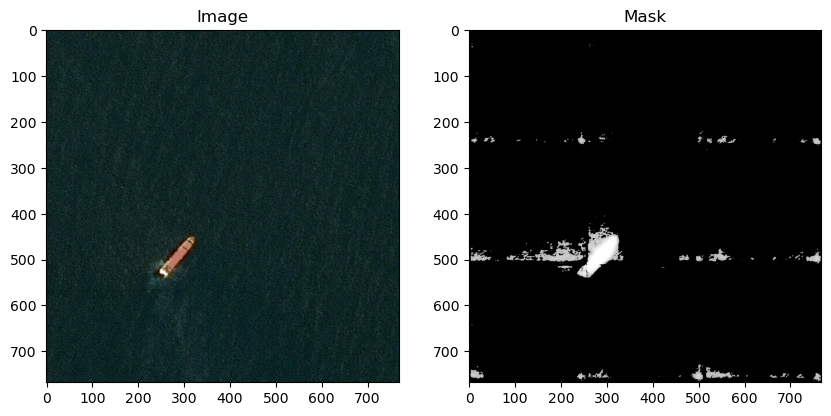

In [27]:
for img_path in img_paths:
    img = read_image(img_path)
    mask = model.predict(img)
    visualize_image_mask(img, mask)